In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()

fatal: destination path 'notebooks' already exists and is not an empty directory.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


# 의도 탐지 예제

In [2]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
query = """Hey, I'd like to rent a vechicle from Nov 1st to Nov 15th in Paris ans I need a 15 passenger van"""

In [4]:
pipe(query)

[{'label': 'car_rental', 'score': 0.5196276307106018}]

# 벤치마크 클래스 만들기

In [5]:
from pathlib import Path

class PerformanceBenchMark:
  def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
    self.pipeline = pipeline
    self.dataset = dataset
    self.optim_type = optim_type

  def compute_accuracy(self):
    preds, labels = [], []
    for example in self.dataset:
      pred = self.pipeline(example["text"])[0]["label"]
      label = example["intent"]
      preds.append(intents.str2int(pred))
      labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"test set accuracy - {accuracy['accuracy']:.3f}")
    return accuracy

  def compute_size(self):
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    size_mb = Path(tmp_path).stat().st_size / (1024 ** 2)

    tmp_path.unlink()
    print(f"model size - {size_mb:.3f} MB")
    return {"size_mb":size_mb}

  def time_pipeline(self):
    latencies = []
    for _ in range(10):
      _ = self.pipeline(query)

    for _ in range(100):
      start_time = perf_counter()
      _ = self.pipeline(query)
      latency = perf_counter() - start_time
      latencies.append(latency)

    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"average latency - {time_avg_ms:.3f} milli seconds +/- {time_std_ms:.2f}")
    return {
        "time_avg_ms": time_avg_ms,
        "time_std_ms": time_std_ms
    }

  def run_benchmark(self):
    metrics = {}
    metrics[self.optim_type] = self.compute_size()
    metrics[self.optim_type].update(self.time_pipeline())
    metrics[self.optim_type].update(self.compute_accuracy())
    return metrics

In [6]:
from datasets import load_dataset
clinc = load_dataset("clinc_oos", "plus")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [8]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

## Examples of intent

In [9]:
count = 0
for _ in range(len(intents.names) // 5):
  for i in range(5):
    print("%30s" % intents.names[count], end="")
    count += 1
  if count % 5 == 0:
    print()

  if count >= 60:
    break

            restaurant_reviews                nutrition_info               account_blocked                oil_change_how                          time
                       weather                redeem_rewards                 interest_rate                      gas_type           accept_reservations
                    smart_home                     user_name              report_lost_card                        repeat                  whisper_mode
         what_are_your_hobbies                         order                    jump_start              schedule_meeting              meeting_schedule
                freeze_account                     what_song               meaning_of_life        restaurant_reservation                       traffic
                     make_call                          text                  bill_balance          improve_credit_score               change_language
                            no        measurement_conversion                         timer    

In [10]:
# !pip install evaluate
import evaluate

accuracy_score = evaluate.load("accuracy")

In [11]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

In [12]:
torch.save(pipe.model.state_dict(), "model.pt")

In [13]:
from time import perf_counter

for _ in range(3):
  start_time = perf_counter()
  _ = pipe(query)
  latency = perf_counter() - start_time
  print(f"Latency: {1000 * latency:.3f} milli seconds")

Latency: 74.165 milli seconds
Latency: 63.380 milli seconds
Latency: 61.766 milli seconds


In [14]:
pb = PerformanceBenchMark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

model size - 418.150 MB
average latency - 70.562 milli seconds +/- 6.11
test set accuracy - 0.867


# Knowledge Distillation

In [15]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
  def __init__(self, *args, alpha=.5, temperature=2.0, **kwargs):
    super().__init__(*args, **kwargs)
    self.alpha = alpha
    self.temperature = temperature

In [16]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
  def __init__(self, *args, teacher_model=None, **kwargs):
    super().__init__(*args, **kwargs)
    self.teacher_model = teacher_model

  def compute_loss(self, model, inputs, return_outputs=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = inputs.to(device)
    outputs_stu = model(**inputs)

    loss_ce = outputs_stu.loss
    logits_stu = outputs_stu.logits

    with torch.no_grad():
      outputs_tea = self.teacher_model(**inputs)
      logits_tea = outputs_tea.logits

    loss_fct = nn.KLDivLoss(reduction="batchmean")
    loss_kd = self.args.temperature ** 2 * loss_fct(
        F.log_softmax(logits_stu / self.args.temperature, dim=-1),
        F.softmax(logits_tea / self.args.temperature, dim=-1)
    )
    loss = self.args.alpha * loss_ce + (1 - self.args.alpha) * loss_kd
    return (loss, outputs_stu) if return_outputs else loss

In [36]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
  return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

In [17]:
from huggingface_hub import notebook_login

notebook_login()

In [18]:
def compute_metrics(pred):
  predictions, labels = pred
  predictions = np.argmax(predictions, axis=1)
  return accuracy_score.compute(predictions=predictions, references=labels)

In [19]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"

In [21]:
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy="epoch",
    num_train_epochs=5, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01, alpha=1, push_to_hub=True
)

In [22]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [23]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels,
                                   id2label=id2label, label2id=label2id)
)

In [24]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
  return (AutoModelForSequenceClassification
          .from_pretrained(student_ckpt, config=student_config)
          .to(device))

In [26]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))
distilbert_trainer = DistillationTrainer(model_init=student_init, teacher_model=teacher_model,
                                         args=student_training_args,
                                         compute_metrics=compute_metrics,
                                         train_dataset=clinc_enc["train"],
                                         eval_dataset=clinc_enc["validation"],
                                         tokenizer=student_tokenizer)

loading configuration file https://huggingface.co/transformersbook/bert-base-uncased-finetuned-clinc/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/9aaec3b8a5073c3fc8736951e59eb092fda4fcac4584f2004239e17cbb10df5c.ad7a70ba622652431d76da8a4fd553d218c0ec90de65cd31dcdbde521dae3567
Model config BertConfig {
  "_name_or_path": "transformersbook/bert-base-uncased-finetuned-clinc",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
  

Download file pytorch_model.bin:   0%|          | 24.1k/256M [00:00<?, ?B/s]

Download file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721554736.5536e8d86346.12770.14:  16%|#5  …

Download file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721552092.5536e8d86346.12770.3:  71%|#####…

Download file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721550760.5536e8d86346.12770.0:  35%|###4 …

Download file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721554051.5536e8d86346.12770.12: 100%|####…

Download file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721556859.5536e8d86346.12770.24: 100%|####…

Clean file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721552092.5536e8d86346.12770.3:   4%|4       …

Download file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721558016.5536e8d86346.12770.28:  37%|###6…

Clean file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721554736.5536e8d86346.12770.14:   2%|1      …

Clean file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721554051.5536e8d86346.12770.12:   7%|6      …

Clean file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721550760.5536e8d86346.12770.0:   4%|4       …

Download file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721556072.5536e8d86346.12770.19:  51%|####…

Clean file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721556859.5536e8d86346.12770.24:   7%|6      …

Clean file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721558016.5536e8d86346.12770.28:   2%|2      …

Clean file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721556072.5536e8d86346.12770.19:   2%|2      …

Download file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721553499.5536e8d86346.12770.10:  57%|####…

Download file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721552472.5536e8d86346.12770.6: 100%|#####…

Download file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721552952.5536e8d86346.12770.8: 100%|#####…

Clean file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721553499.5536e8d86346.12770.10:   7%|6      …

Download file runs/Jul21_08-14-06_5536e8d86346/1721556859.4368298/events.out.tfevents.1721556859.5536e8d86346.…

Download file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721557470.5536e8d86346.12770.26: 100%|####…

Download file runs/Jul21_08-14-06_5536e8d86346/1721556072.8197594/events.out.tfevents.1721556072.5536e8d86346.…

Clean file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721552472.5536e8d86346.12770.6:   7%|7       …

Clean file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721552952.5536e8d86346.12770.8:   7%|6       …

Clean file runs/Jul21_08-14-06_5536e8d86346/1721556859.4368298/events.out.tfevents.1721556859.5536e8d86346.127…

Clean file runs/Jul21_08-14-06_5536e8d86346/events.out.tfevents.1721557470.5536e8d86346.12770.26:   7%|6      …

Download file runs/Jul21_08-14-06_5536e8d86346/1721556132.5913231/events.out.tfevents.1721556132.5536e8d86346.…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721556072.8197594/events.out.tfevents.1721556072.5536e8d86346.127…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721556132.5913231/events.out.tfevents.1721556132.5536e8d86346.127…

Download file runs/Jul21_08-14-06_5536e8d86346/1721556252.628195/events.out.tfevents.1721556252.5536e8d86346.1…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721556252.628195/events.out.tfevents.1721556252.5536e8d86346.1277…

Download file runs/Jul21_08-14-06_5536e8d86346/1721558016.5903966/events.out.tfevents.1721558016.5536e8d86346.…

Download file runs/Jul21_08-14-06_5536e8d86346/1721557470.093796/events.out.tfevents.1721557470.5536e8d86346.1…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721558016.5903966/events.out.tfevents.1721558016.5536e8d86346.127…

Download file runs/Jul21_08-14-06_5536e8d86346/1721555463.534911/events.out.tfevents.1721555463.5536e8d86346.1…

Download file runs/Jul21_08-14-06_5536e8d86346/1721556192.537672/events.out.tfevents.1721556192.5536e8d86346.1…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721557470.093796/events.out.tfevents.1721557470.5536e8d86346.1277…

Download file runs/Jul21_08-14-06_5536e8d86346/1721558077.5405777/events.out.tfevents.1721558077.5536e8d86346.…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721555463.534911/events.out.tfevents.1721555463.5536e8d86346.1277…

Download file runs/Jul21_08-14-06_5536e8d86346/1721558137.2719495/events.out.tfevents.1721558137.5536e8d86346.…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721556192.537672/events.out.tfevents.1721556192.5536e8d86346.1277…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721558077.5405777/events.out.tfevents.1721558077.5536e8d86346.127…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721558137.2719495/events.out.tfevents.1721558137.5536e8d86346.127…

Download file runs/Jul21_08-14-06_5536e8d86346/1721555403.6525705/events.out.tfevents.1721555403.5536e8d86346.…

Download file runs/Jul21_08-14-06_5536e8d86346/1721558197.319008/events.out.tfevents.1721558197.5536e8d86346.1…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721555403.6525705/events.out.tfevents.1721555403.5536e8d86346.127…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721558197.319008/events.out.tfevents.1721558197.5536e8d86346.1277…

Download file runs/Jul21_08-14-06_5536e8d86346/1721554736.3876805/events.out.tfevents.1721554736.5536e8d86346.…

Download file runs/Jul21_08-14-06_5536e8d86346/1721554051.708327/events.out.tfevents.1721554051.5536e8d86346.1…

Download file runs/Jul21_08-14-06_5536e8d86346/1721553499.5322495/events.out.tfevents.1721553499.5536e8d86346.…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721553499.5322495/events.out.tfevents.1721553499.5536e8d86346.127…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721554051.708327/events.out.tfevents.1721554051.5536e8d86346.1277…

Download file runs/Jul21_08-14-06_5536e8d86346/1721555343.8441796/events.out.tfevents.1721555343.5536e8d86346.…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721554736.3876805/events.out.tfevents.1721554736.5536e8d86346.127…

Download file runs/Jul21_08-14-06_5536e8d86346/1721552952.1483848/events.out.tfevents.1721552952.5536e8d86346.…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721555343.8441796/events.out.tfevents.1721555343.5536e8d86346.127…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721552952.1483848/events.out.tfevents.1721552952.5536e8d86346.127…

Download file runs/Jul21_08-14-06_5536e8d86346/1721552124.6372585/events.out.tfevents.1721552124.5536e8d86346.…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721552124.6372585/events.out.tfevents.1721552124.5536e8d86346.127…

Download file runs/Jul21_08-14-06_5536e8d86346/1721552472.5895047/events.out.tfevents.1721552472.5536e8d86346.…

Download file runs/Jul21_08-14-06_5536e8d86346/1721551007.8127842/events.out.tfevents.1721551007.5536e8d86346.…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721552472.5895047/events.out.tfevents.1721552472.5536e8d86346.127…

Download file runs/Jul21_08-14-06_5536e8d86346/1721552092.2375395/events.out.tfevents.1721552092.5536e8d86346.…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721551007.8127842/events.out.tfevents.1721551007.5536e8d86346.127…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721552092.2375395/events.out.tfevents.1721552092.5536e8d86346.127…

Download file training_args.bin: 100%|##########| 3.49k/3.49k [00:00<?, ?B/s]

Clean file training_args.bin:  29%|##8       | 1.00k/3.49k [00:00<?, ?B/s]

Download file runs/Jul21_08-14-06_5536e8d86346/1721550760.9984972/events.out.tfevents.1721550760.5536e8d86346.…

Clean file runs/Jul21_08-14-06_5536e8d86346/1721550760.9984972/events.out.tfevents.1721550760.5536e8d86346.127…

Clean file pytorch_model.bin:   0%|          | 1.00k/256M [00:00<?, ?B/s]

In [27]:
distilbert_trainer.train()

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.288450,0.741935
2,3.786500,1.875109,0.836774
3,3.786500,1.156888,0.896129
4,1.692500,0.857329,0.913226
5,0.905600,0.772118,0.918065


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/checkpoint-1000
Configuration saved in distilbert-

TrainOutput(global_step=1590, training_loss=2.0511699076718504, metrics={'train_runtime': 344.8599, 'train_samples_per_second': 221.104, 'train_steps_per_second': 4.611, 'total_flos': 413896353421488.0, 'train_loss': 2.0511699076718504, 'epoch': 5.0})

In [28]:
distilbert_trainer.push_to_hub("Training Completed!")

Saving model checkpoint to distilbert-base-uncased-finetuned-clinc
Configuration saved in distilbert-base-uncased-finetuned-clinc/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json


Upload file runs/Jul22_06-21-55_5ea936e2f4b1/events.out.tfevents.1721629418.5ea936e2f4b1.1929.0:   0%|        …

To https://huggingface.co/blue2959/distilbert-base-uncased-finetuned-clinc
   028a411..3811b54  main -> main

   028a411..3811b54  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.9180645161290323}]}


'https://huggingface.co/blue2959/distilbert-base-uncased-finetuned-clinc/commit/3811b5404e92d774f5a1ead84950b8842664ab9f'

In [21]:
finetuned_ckpt = "blue2959/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

In [22]:
optim_type = "DistilBERT"
pb = PerformanceBenchMark(pipe, clinc["test"], optim_type)
perf_metrics.update(pb.run_benchmark())

model size - 255.881 MB
average latency - 33.781 milli seconds +/- 2.03
test set accuracy - 0.847


In [25]:
import pandas as pd

def plot_metrics(perf_metrics, current_optim_type):
  df = pd.DataFrame.from_dict(perf_metrics, orient="index")
  for idx in df.index:
    df_opt = df.loc[idx]

    if idx == current_optim_type:
      plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                  alpha = .5, s = df_opt["size_mb"], label=idx,
                  marker="$\u25CC$")
    else:
      plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                  alpha = .5, s = df_opt["size_mb"], label=idx)
  legend = plt.legend(bbox_to_anchor=(1, 1))
  for handle in legend.legend_handles:
    handle.set_sizes([20])

  plt.ylim(80, 90)
  xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
  plt.xlim(1, xlim)
  plt.ylabel("Accuracy (%)")
  plt.xlabel("Latency (ms)")
  plt.grid(True)
  plt.show()

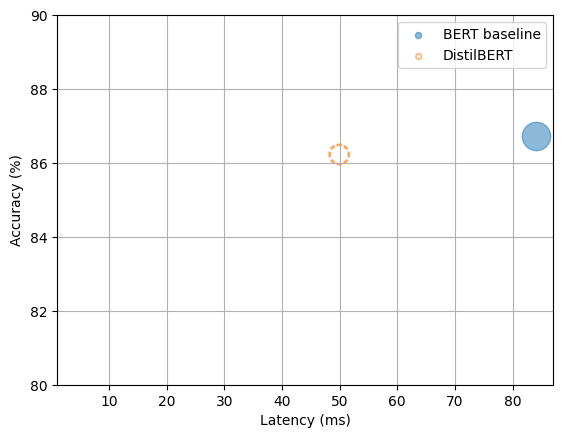

In [32]:
plot_metrics(perf_metrics, optim_type)

### HyperParameter Searching (alpha, Temperature) using Optuna

In [33]:
def objective(trial):
  x = trial.suggest_float("x", -2, 2)
  y = trial.suggest_float("y", -2, 2)
  return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

In [34]:
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2024-07-22 06:32:17,699] A new study created in memory with name: no-name-a3334b0f-42b7-4b99-b3fb-aad2e296767d
[I 2024-07-22 06:32:17,702] Trial 0 finished with value: 14.809221626306288 and parameters: {'x': 1.2472741163315764, 'y': 1.93972497431333}. Best is trial 0 with value: 14.809221626306288.
[I 2024-07-22 06:32:17,703] Trial 1 finished with value: 151.76611376091716 and parameters: {'x': -0.01614714774719328, 'y': 1.2279966903287716}. Best is trial 0 with value: 14.809221626306288.
[I 2024-07-22 06:32:17,705] Trial 2 finished with value: 755.2673468186855 and parameters: {'x': -1.380232508663072, 'y': -0.8328439757151194}. Best is trial 0 with value: 14.809221626306288.
[I 2024-07-22 06:32:17,708] Trial 3 finished with value: 256.53267029294625 and parameters: {'x': 1.8547474487514792, 'y': 1.840706727332451}. Best is trial 0 with value: 14.809221626306288.
[I 2024-07-22 06:32:17,710] Trial 4 finished with value: 30.408875557656916 and parameters: {'x': 0.03997816003686028, 

In [35]:
study.best_params

{'x': 1.0083035026166032, 'y': 1.0184166401475567}

In [36]:
def hp_space(trial):
  return {
      "num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
      "alpha": trial.suggest_float("alpha", 0, 1),
      "temperature": trial.suggest_int("temperature", 2, 20)
  }


In [37]:
best_run = distilbert_trainer.hyperparameter_search(
    hp_space=hp_space, n_trials=5, direction="maximize")

[I 2024-07-22 06:32:34,396] A new study created in memory with name: no-name-3bb67854-276c-4b6b-b13d-0cad7e174ea3
Trial:
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertF

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.424259,0.660323
2,0.651400,0.162943,0.832903
3,0.651400,0.087499,0.887742
4,0.184700,0.063752,0.906774
5,0.098900,0.054930,0.912581
6,0.098900,0.052289,0.915484


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-100

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.206672,0.573226
2,0.319500,0.107820,0.805161
3,0.319500,0.077095,0.867419
4,0.123200,0.064698,0.888065
5,0.088500,0.060853,0.894194


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-100

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.211111,0.613871
2,0.334500,0.099191,0.839032
3,0.334500,0.063567,0.890323
4,0.114200,0.047661,0.906452
5,0.070600,0.038870,0.913226
6,0.070600,0.033967,0.920323
7,0.054600,0.030868,0.921613
8,0.047000,0.028957,0.927097
9,0.047000,0.027809,0.926129
10,0.043500,0.027458,0.927419


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-100

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.197855,0.581613
2,0.310700,0.098868,0.821290
3,0.310700,0.067267,0.881935
4,0.113100,0.053074,0.897742
5,0.075100,0.045458,0.908387
6,0.075100,0.041739,0.910968
7,0.062100,0.040445,0.912258


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-100

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.252433,0.633871
2,0.398900,0.109573,0.848065
3,0.398900,0.065652,0.893548
4,0.126800,0.047416,0.908710
5,0.073800,0.038391,0.920323
6,0.073800,0.033445,0.924839
7,0.056100,0.030465,0.924194
8,0.048100,0.028644,0.930000
9,0.048100,0.027552,0.928387
10,0.044500,0.027222,0.929677


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-100

In [38]:
print(best_run)

BestRun(run_id='4', objective=0.9296774193548387, hyperparameters={'num_train_epochs': 10, 'alpha': 0.481593574555624, 'temperature': 4})


In [50]:
for k, v in best_run.hyperparameters.items():
  setattr(student_training_args, k, v)
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

distil_trainer = DistillationTrainer(model_init=student_init,
                                      teacher_model=teacher_model, args=student_training_args,
                                      train_dataset=clinc_enc["train"], eval_dataset=clinc_enc["validation"],
                                      compute_metrics=compute_metrics, tokenizer=student_tokenizer)
distil_trainer.train()

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.700882,0.757097
2,2.019000,0.887435,0.872258
3,2.019000,0.509565,0.920968
4,0.791500,0.353156,0.937097
5,0.356800,0.288533,0.944194
6,0.356800,0.260234,0.947419
7,0.228000,0.245237,0.948710
8,0.184200,0.238934,0.948387
9,0.184200,0.236112,0.948387
10,0.169400,0.234165,0.949032


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-distilled-clinc/checkpoint-500
Configuration saved in distilbert-base-uncased-distilled-clinc/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-distilled-clinc/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-distilled-clinc/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-distilled-clinc/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-distilled-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-distilled-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-distilled-clinc/checkpoint-1000
Configuration saved in distilbert-

TrainOutput(global_step=3180, training_loss=0.5987570966564635, metrics={'train_runtime': 690.3039, 'train_samples_per_second': 220.917, 'train_steps_per_second': 4.607, 'total_flos': 827475185485200.0, 'train_loss': 0.5987570966564635, 'epoch': 10.0})

In [51]:
distil_trainer.push_to_hub("Training Completed!")

Saving model checkpoint to distilbert-base-uncased-distilled-clinc
Configuration saved in distilbert-base-uncased-distilled-clinc/config.json
Model weights saved in distilbert-base-uncased-distilled-clinc/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-distilled-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-distilled-clinc/special_tokens_map.json
To https://huggingface.co/blue2959/distilbert-base-uncased-distilled-clinc
   5ee6a22..115d68a  main -> main

   5ee6a22..115d68a  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.9490322580645161}]}


'https://huggingface.co/blue2959/distilbert-base-uncased-distilled-clinc/commit/115d68afb5923cd67c7814577566193314079ef9'

In [54]:
distilled_ckpt = "blue2959/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchMark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

model size - 255.881 MB
average latency - 37.986 milli seconds +/- 7.43
test set accuracy - 0.879


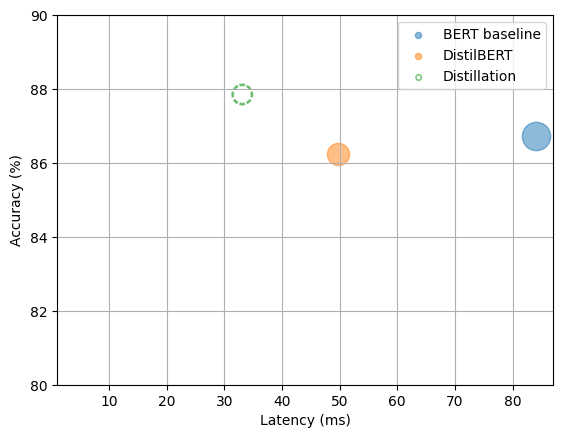

In [54]:
plot_metrics(perf_metrics, optim_type)

# Quantization

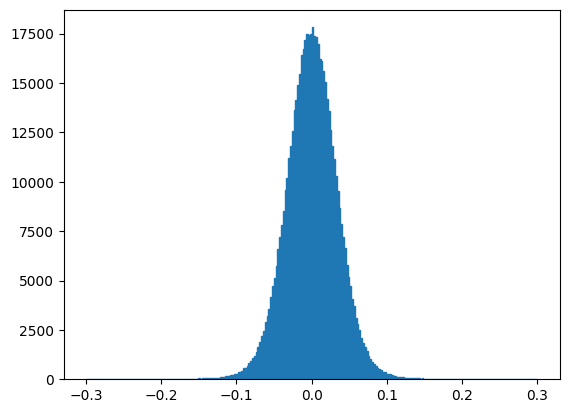

In [55]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-.3, .3), edgecolor="C0")
plt.show()

In [56]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

In [57]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -7,   0,  ...,  -6,  -4,   8],
        [  9,   2,   1,  ...,  -4,   7,   1],
        [ -9,  -6,   5,  ...,   1,   6,  -4],
        ...,
        [  5,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [58]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -7,   0,  ...,  -6,  -4,   8],
        [  9,   2,   1,  ...,  -4,   7,   1],
        [ -9,  -6,   5,  ...,   1,   6,  -4],
        ...,
        [  5,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

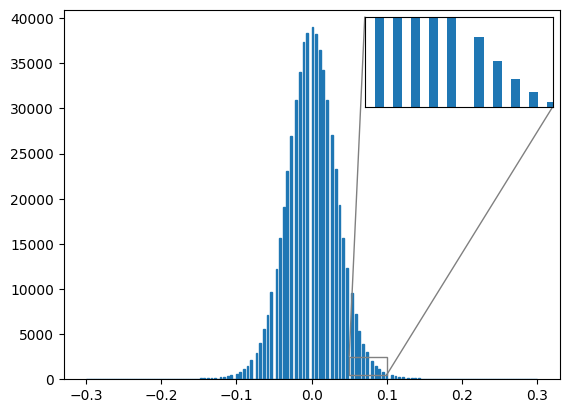

In [59]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

fig, ax = plt.subplots()
ax.hist(quantized_weights.dequantize().flatten().numpy(),
        bins=250, range=(-.3, .3), edgecolor="C0")
axins = zoomed_inset_axes(ax, 5, loc="upper right")
axins.hist(quantized_weights.dequantize().flatten().numpy(),
           bins=250, range=(-.3, .3));
x1, x2, y1, y2 = .05, .1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

In [60]:
weights.dtype

torch.float32

In [61]:
%%timeit
weights @ weights

2.18 ms ± 366 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [61]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [62]:
quantized_weights.dtype

torch.qint8

In [66]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

The slowest run took 34.51 times longer than the fastest. This could mean that an intermediate result is being cached.
634 µs ± 670 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [63]:
import sys
sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

<ipython-input-63-e8c20105a3d3>:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())


3.999755879241598

In [64]:
from torch.quantization import quantize_dynamic
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_ckpt = "blue2959/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))
model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

In [65]:
pipe = pipeline("text-classification", model=model_quantized,
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchMark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

model size - 132.391 MB
average latency - 14.421 milli seconds +/- 1.15
test set accuracy - 0.884


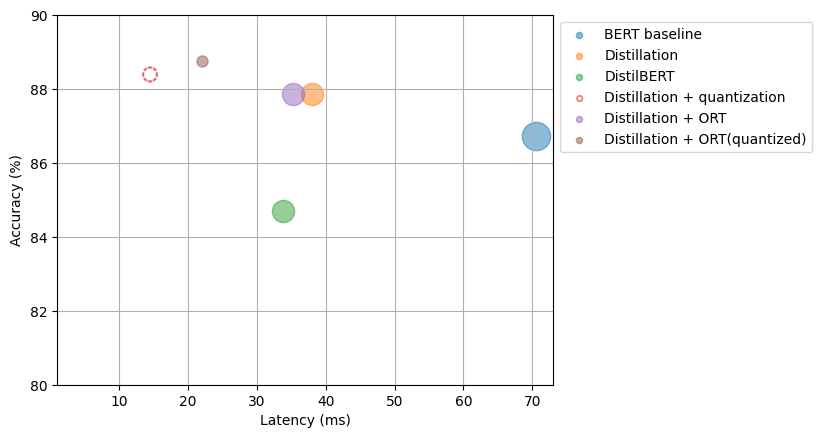

In [66]:
plot_metrics(perf_metrics, optim_type)

## Optimization with ONNX

In [67]:
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [69]:
from transformers.convert_graph_to_onnx import convert

model_ckpt = "blue2959/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer,
        output=onnx_model_path, opset=12, pipeline_name="text-classification")

ONNX opset version set to: 12
Loading pipeline (model: blue2959/distilbert-base-uncased-distilled-clinc, tokenizer: PreTrainedTokenizerFast(name_or_path='blue2959/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}))


Exception: Folder onnx is not empty, aborting conversion

In [70]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession,
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
  options = SessionOptions()
  options.intra_op_num_threads = 1
  options.graph_optimization_level = GraphOptimizationLevel.ORT_DISABLE_ALL
  session = InferenceSession(model_path, options, providers=[provider])
  session.disable_fallback()
  return session

In [71]:
onnx_model = create_model_for_provider(onnx_model_path)

In [72]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

In [73]:
np.argmax(logits_onnx)

61

In [74]:
clinc_enc["test"][0]["labels"]

61

In [75]:
from scipy.special import softmax

class OnnxPipeline:
  def __init__(self, model, tokenizer):
    self.model = model
    self.tokenizer = tokenizer

  def __call__(self, query):
    model_inputs = self.tokenizer(query, return_tensors="pt")
    inputs_onnx = {k:v.cpu().detach().numpy()
                  for k, v in model_inputs.items()}
    logits = self.model.run(None, inputs_onnx)[0][0, :]
    probs = softmax(logits)
    pred_idx = np.argmax(probs).item()
    return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [76]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.8718959}]

In [77]:
class OnnxPerformanceBenchMark(PerformanceBenchMark):
  def __init__(self, *args, model_path, **kwargs):
    super().__init__(*args, **kwargs)
    self.model_path = model_path

  def compute_size(self):
    size_mb = Path(self.model_path).stat().st_size / (1024 ** 2)
    print(f"model size - {size_mb:.3f} MB")
    return {"size_mb": size_mb}

In [78]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchMark(pipe, clinc["test"], optim_type=optim_type,
                               model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

model size - 255.978 MB
average latency - 35.740 milli seconds +/- 1.45
test set accuracy - 0.879


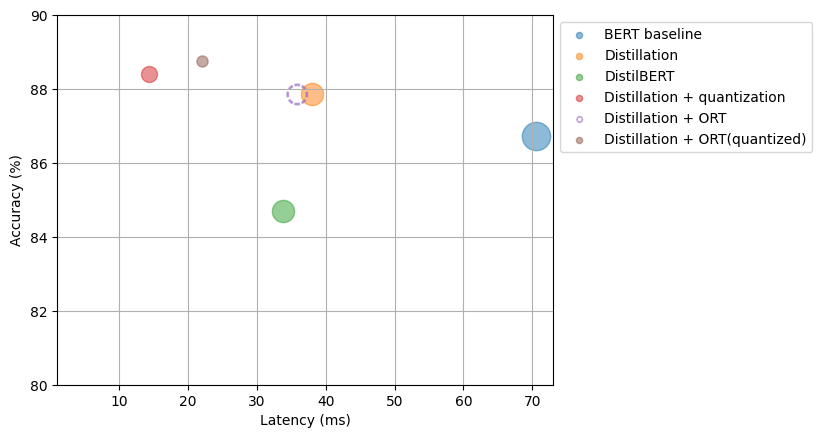

In [79]:
plot_metrics(perf_metrics, optim_type)

In [80]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

In [81]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT(quantized)"
pb = OnnxPerformanceBenchMark(pipe, clinc["test"], optim_type=optim_type,
                               model_path=model_output)
perf_metrics.update(pb.run_benchmark())

model size - 64.357 MB
average latency - 22.669 milli seconds +/- 1.04
test set accuracy - 0.888


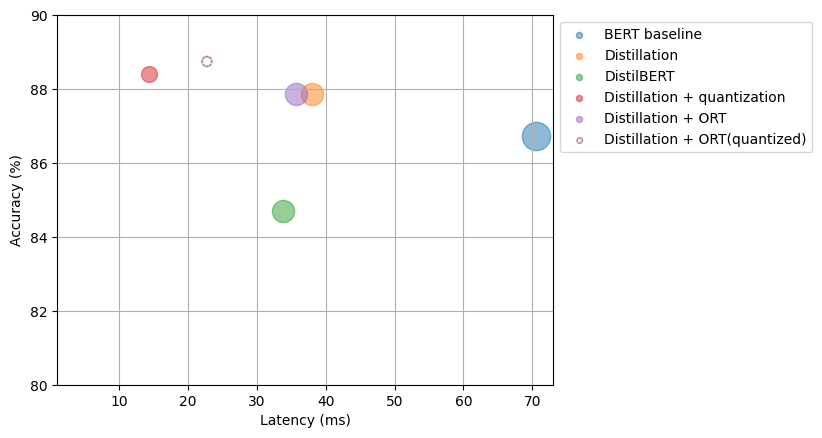

In [83]:
plot_metrics(perf_metrics, optim_type)

# Making Models Sparser with Weight Pruning

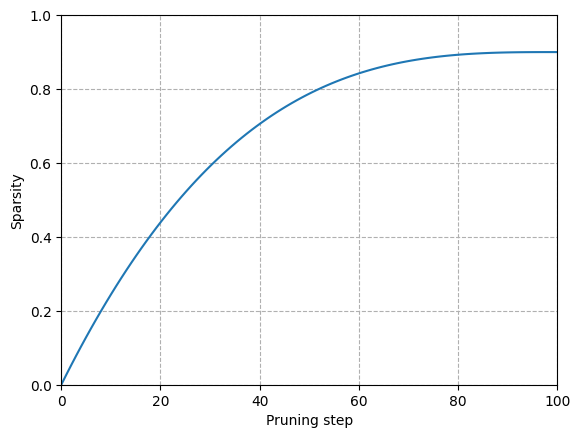

In [84]:

#hide_input
#id sparsity-scheduler
#alt Sparsity scheduler
#caption The cubic sparsity scheduler used for pruning
import numpy as np
import matplotlib.pyplot as plt

def _sparsity(t, t_0=0, dt=1, s_i=0, s_f=0.9, N=100):
    return s_f + (s_i - s_f) * (1 - (t - t_0) / (N * dt))**3

steps = np.linspace(0,100,100)
values = [_sparsity(t) for t in steps]

fig, ax = plt.subplots()
ax.plot(steps, values)
ax.set_ylim(0,1)
ax.set_xlim(0,100)
ax.set_xlabel("Pruning step")
ax.set_ylabel("Sparsity")
plt.grid(linestyle="dashed")
plt.show()